
# OLID Hate/Offensive Language Classifier – End‑to‑End Training (Team Report)

In this notebook, we document our **team’s** end‑to‑end pipeline for training a binary classifier on Twitter‑style text for **foul (1)** vs **proper (0)** detection. We blended a concise academic style with a presentation‑oriented narrative to make the workflow easy to follow.

**Our plan:**
1) Load and normalize the dataset (e.g., `data/labeled_data.csv`, Hate Speech and Offensive Language Dataset from Kaggle ==> https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset).
2) Apply text cleaning that we can **match at inference time** to avoid train‑inference drift. (RegEX, Punctuation, Stop Words)
3) Split data into train/validation and mitigate class imbalance via simple positive oversampling.
4) Train three baselines: **Logistic Regression (TF‑IDF)**, **Calibrated Linear SVM (TF‑IDF)**, **Multinomial NB (BOW)**.
5) Evaluate at **t = 0.50** (Accuracy, Precision, Recall, F1, ROC‑AUC, PR‑AUC), visualize a confusion matrix and save artifacts.  (`artifacts/confusion_matrix.png` `metrics.json`)
6) Select the best model and save artifacts to `artifacts/` (`model.pkl`).



## Reproducibility and Design Choices (Team Perspective)

- We aligned preprocessing between training and inference to ensure consistent text normalization, avoiding discrepancies such as treating “f*ck” and “f ck” as different tokens.
- Our primary design goal was to achieve recall ≥ 0.80 while maintaining a balanced trade-off between precision and recall, ensuring the model remains robust and fair.
- Instead of maximizing a single metric, we focused on balanced performance, prioritizing recall first and then validating F1 and ROC-AUC to confirm overall reliability.
- We relied on lightweight, interpretable models to simplify iteration and keep the pipeline transparent, using a straightforward oversampling strategy to lift recall without overfitting.


In [1]:

%matplotlib inline

import re
import pickle
import json
from pathlib import Path
import nltk
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)

print("Versions → pandas:", pd.__version__)


Versions → pandas: 2.3.3


## Paths & Configuration

This section defines the main project structure and configuration settings.
We specify the dataset path and output directory for all artifacts, including models and metrics.
A fixed random seed (RANDOM_STATE = 42) ensures reproducibility and consistent experimental results.

In [2]:

DATA_PATH = Path("data/labeled_data.csv")
ART_DIR = Path("artifacts")
ART_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = ART_DIR / "model.pkl"
METRICS_PATH = ART_DIR / "metrics.json"
CM_PNG = ART_DIR / "confusion_matrix.png"

RANDOM_STATE = 42

print({'DATA_PATH': str(DATA_PATH), 'ART_DIR': str(ART_DIR)})


{'DATA_PATH': 'data/labeled_data.csv', 'ART_DIR': 'artifacts'}


## Stopwords & Emoji Pattern

Here we prepare preprocessing rules to reduce noise in the text.
We extend NLTK’s English stopword list with context-specific words such as “you” and “ur”, which often distort meaning in offensive language detection.
We also compile a regex pattern to remove emojis, ensuring the model focuses purely on linguistic content.

In [3]:

try:
    from nltk.corpus import stopwords
    STOP_WORDS = set(stopwords.words('english'))
    STOP_WORDS.update(['you', 'your', 'yours', 'yourself', 'u', 'ur'])
except LookupError:
    print("NLTK stopwords not found. Downloading...")
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    STOP_WORDS = set(stopwords.words('english'))
    STOP_WORDS.update(['you', 'your', 'yours', 'yourself', 'u', 'ur'])

EMOJI_PATTERN = re.compile(
    "[" "\\U0001F600-\\U0001F64F" "\\U0001F300-\\U0001F5FF"
    "\\U0001F680-\\U0001F6FF" "\\U0001F1E0-\\U0001F1FF"
    "\\u2600-\\u26FF" "\\u2700-\\u27BF" "]+",
    flags=re.UNICODE
)


## Utilities: Cleaning & Metrics

This section defines the key utility functions used throughout the pipeline.
The clean_tweet() function standardizes text by removing URLs, mentions, emojis, numbers, and redundant punctuation while optionally preserving apostrophes.
It ensures that only linguistically meaningful tokens remain for feature extraction.

The evaluate_probs() function computes key evaluation metrics such as accuracy, precision, recall, F1-scores, ROC-AUC, and PR-AUC at a given threshold.
It also generates and saves a confusion matrix plot for visual performance analysis, providing both numerical and graphical insight into model behavior.

In [4]:

def clean_tweet(text: str,
                remove_punct: bool = False,
                collapse_punct: bool = True,
                keep_apostrophe: bool = True) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()

    t = re.sub(r"http\S+|www\S+|https\S+", "", t)
    t = re.sub(r"@\w+", "", t)
    t = re.sub(r"#", "", t)
    t = EMOJI_PATTERN.sub("", t)
    t = re.sub(r"\d+", "", t)

    t = re.sub(r"^\s*rt\b:?\s*", "", t)
    t = re.sub(r"\brt\b:?", "", t)

    if collapse_punct:
        t = re.sub(r"([!?.,])\1+", r"\1", t)
        t = re.sub(r"^[!?.,]+", "", t)
        t = re.sub(r"[!?.,]+$", "", t)

    if remove_punct:
        keep = "'" if keep_apostrophe else ""
        t = re.sub(fr"[^\w\s{keep}]", " ", t)

    t = re.sub(r"\s+", " ", t).strip()
    return t


def evaluate_probs(proba, y_true, threshold=0.50, title="Validation", save_cm_path=None):
    y_pred = (proba >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1w = f1_score(y_true, y_pred, average="weighted", zero_division=0)
    f1m = f1_score(y_true, y_pred, average="macro", zero_division=0)

    precision, recall, _ = precision_recall_curve(y_true, proba)
    pr_auc = auc(recall, precision)
    try:
        roc_auc = roc_auc_score(y_true, proba)
    except Exception:
        roc_auc = float("nan")

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    if save_cm_path is not None:
        fig = plt.figure()
        plt.imshow(cm, interpolation='nearest')
        plt.title(f'Confusion Matrix (Artifact) — {title} @t={threshold:.2f}')
        plt.colorbar()
        ticks = np.arange(2)
        plt.xticks(ticks, ['proper(0)', 'foul(1)'], rotation=45)
        plt.yticks(ticks, ['proper(0)', 'foul(1)'])
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, cm[i, j], ha='center',
                         color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        fig.savefig(save_cm_path, dpi=140)
        plt.close(fig)

    print(f"\n== {title} @ threshold={threshold:.2f} ==")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1(weighted): {f1w:.4f}")
    print(f"F1(macro): {f1m:.4f} | ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")
    print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))

    return {
        "accuracy": acc, "precision": prec, "recall": rec,
        "f1_weighted": f1w, "f1_macro": f1m,
        "roc_auc": roc_auc, "pr_auc": pr_auc,
        "threshold": float(threshold),
        "support": {"class_0": int((y_true == 0).sum()), "class_1": int((y_true == 1).sum())}
    }, cm



## Load Dataset & Normalize Columns (Our Steps)

We require the following columns:
- `text`: the tweet/message
- `label`: either binary (0/1) or a 3‑class scheme such as `hate_speech/offensive_language/neither`.
  We collapse 0/1/2 into **1/1/0** and string labels into **1 (foul)** and **0 (proper)**.

To maximize compatibility with public datasets, we also map `tweet → text` and `class → label` if needed.

In [5]:

assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}."
df = pd.read_csv(DATA_PATH)

df.columns = [col.strip().lower() for col in df.columns]

if "class" in df.columns and "label" not in df.columns:
    df = df.rename(columns={"class": "label"})
if "tweet" in df.columns and "text" not in df.columns:
    df = df.rename(columns={"tweet": "text"})
if "subtask_a" in df.columns and "label" not in df.columns:
    df = df.rename(columns={"subtask_a": "label"})

assert {"text", "label"}.issubset(set(df.columns)), (
    f"CSV must contain 'text' and 'label'. Columns found: {list(df.columns)}"
)

df = df.dropna(subset=["text", "label"]).copy()
df["text"] = df["text"].astype(str)

if df["label"].dtype == object:
    _map = {
        "off": 1, "offensive": 1,
        "not": 0, "neither": 0,
        "hate_speech": 1, "hate": 1,
        "offensive_language": 1,
        "clean": 0, "normal": 0
    }
    df["label"] = df["label"].str.lower().map(_map)
else:
    vals = set(pd.unique(df["label"].dropna()))
    if vals.issuperset({0, 1}) and 2 in vals:
        df["label"] = df["label"].astype(int).map({0: 1, 1: 1, 2: 0})

df = df.dropna(subset=["label"]).copy()
df["label"] = df["label"].astype(int)
df.head(3)


,unnamed: 0,count,hate_speech,offensive_language,neither,label,text
0,0,3,0,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


## Text Cleaning

In this step, raw text data is preprocessed using the clean_tweet() function.
The goal is to remove unnecessary elements—such as links, emojis, mentions, and extra punctuation—while preserving the core linguistic content.
A new column, clean_text, is created to store the cleaned version of each tweet, allowing for direct comparison between the original and processed text.
This ensures the downstream models receive standardized, noise-free input for training and evaluation.



In [6]:

print("Cleaning text data...")
df["clean_text"] = df["text"].apply(clean_tweet)
df[["text","clean_text","label"]].head(8)


Cleaning text data...


,text,clean_text,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,: as a woman you shouldn't complain about clea...,0
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,: boy dats cold.tyga dwn bad for cuffin dat ho...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg! : you ever fuck a bitch and she start to...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,: she look like a tranny,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,: the shit you hear about me might be true or ...,1
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",""": the shit just blows me.claim you so faithfu...",1
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",""": i can not just sit up and hate on another b...",1
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,&;: cause i'm tired of you big bitches coming ...,1


## Train/Validation Split & Oversampling

In this step, the dataset is divided into training (80%) and validation (20%) subsets using stratified sampling to preserve class balance.
To address the natural imbalance in offensive language datasets, we apply simple oversampling on the positive (foul) class, duplicating those samples to improve recall without altering data distribution.
This ensures the model is exposed to enough minority examples during training, helping it better detect offensive content.

In [11]:

X_train, X_val, y_train, y_val = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, stratify=df["label"], random_state=RANDOM_STATE
)

pos_mask = (y_train == 1)
if pos_mask.sum() == 0:
    print("Warning: No positive (foul) labels found in training data. Skipping oversampling.")
    X_train_os, y_train_os = X_train, y_train
else:
    X_train_os = pd.concat([X_train, X_train[pos_mask]], ignore_index=True)
    y_train_os = pd.concat([y_train, y_train[pos_mask]], ignore_index=True)

len(X_train), len(X_train_os)


(19826, 36322)

## Models (Character N‑grams)

This section defines three machine learning models using character-level n-gram features (ranging from 2 to 5 characters).
Character n-grams help capture subword patterns such as slang, misspellings, and variations in offensive expressions (e.g., “fck”*, “fvck”).

We implemented and compared three lightweight classifiers:
- Logistic Regression (TF-IDF) — effective for linearly separable text features.
- Linear SVM (TF-IDF) — robust to high-dimensional sparse vectors.
- Multinomial Naive Bayes (Count-based) — efficient for probabilistic text modeling.

All pipelines are configured with balanced class weights and regularization to ensure stable performance on imbalanced datasets.
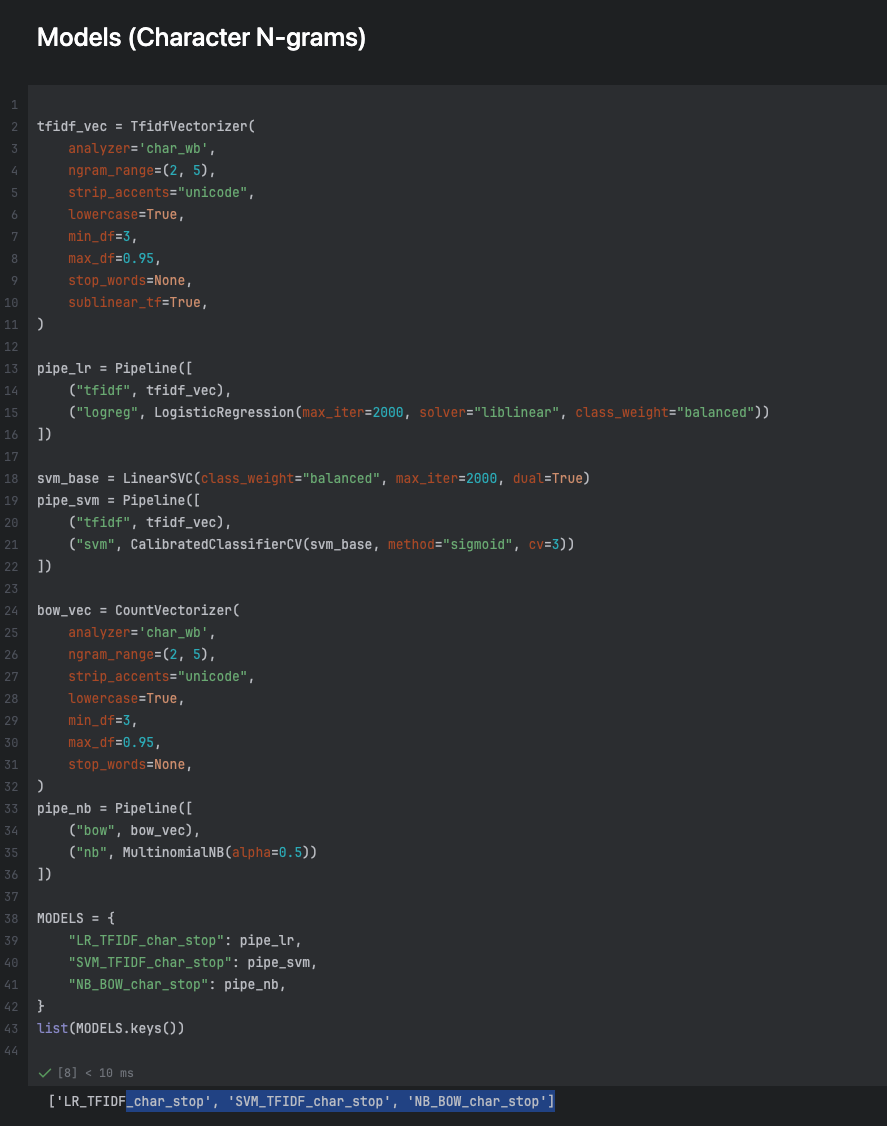

In [12]:

tfidf_vec = TfidfVectorizer(
    analyzer='char_wb',
    ngram_range=(2, 5),
    strip_accents="unicode",
    lowercase=True,
    min_df=3,
    max_df=0.95,
    stop_words=None,
    sublinear_tf=True,
)

pipe_lr = Pipeline([
    ("tfidf", tfidf_vec),
    ("logreg", LogisticRegression(max_iter=2000, solver="liblinear", class_weight="balanced"))
])

svm_base = LinearSVC(class_weight="balanced", max_iter=2000, dual=True)
pipe_svm = Pipeline([
    ("tfidf", tfidf_vec),
    ("svm", CalibratedClassifierCV(svm_base, method="sigmoid", cv=3))
])

bow_vec = CountVectorizer(
    analyzer='char_wb',
    ngram_range=(2, 5),
    strip_accents="unicode",
    lowercase=True,
    min_df=3,
    max_df=0.95,
    stop_words=None,
)
pipe_nb = Pipeline([
    ("bow", bow_vec),
    ("nb", MultinomialNB(alpha=0.5))
])

MODELS = {
    "LR_TFIDF_char_stop": pipe_lr,
    "SVM_TFIDF_char_stop": pipe_svm,
    "NB_BOW_char_stop": pipe_nb,
}
list(MODELS.keys())


['LR_TFIDF_char_stop', 'SVM_TFIDF_char_stop', 'NB_BOW_char_stop']

## Train, Evaluate @ t=0.50, Show Confusion Matrices, and Select Best

Each model is trained using the oversampled training set and evaluated on the validation set with a default threshold of 0.50.
Predicted probabilities (or decision scores) are used to compute standard classification metrics — accuracy, precision, recall, F1, ROC-AUC, and PR-AUC.

For visualization, a confusion matrix is displayed after each model’s evaluation, providing insight into false positives and false negatives.
The best-performing model is automatically selected based on a composite key prioritizing weighted F1, then precision, and finally ROC-AUC.

This ensures a balanced model that achieves strong recall on offensive content while maintaining overall classification reliability.


[Training] LR_TFIDF_char_stop

== Validation [LR_TFIDF_char_stop] @ threshold=0.50 ==
Accuracy: 0.9411 | Precision: 0.9908 | Recall: 0.9379 | F1(weighted): 0.9437
F1(macro): 0.9044 | ROC-AUC: 0.9836 | PR-AUC: 0.9966

Classification report:
               precision    recall  f1-score   support

           0     0.7569    0.9568    0.8452       833
           1     0.9908    0.9379    0.9636      4124

    accuracy                         0.9411      4957
   macro avg     0.8738    0.9474    0.9044      4957
weighted avg     0.9515    0.9411    0.9437      4957



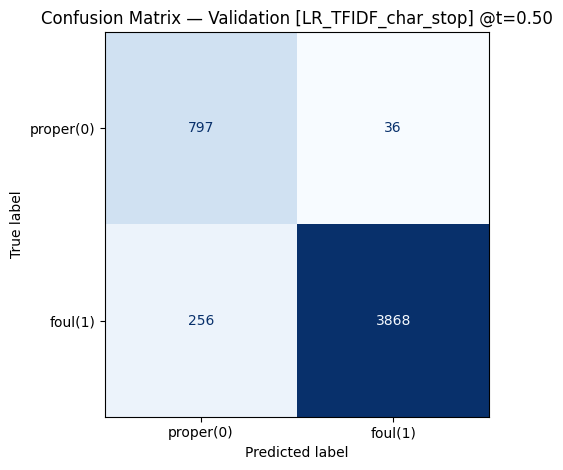


[Training] SVM_TFIDF_char_stop

== Validation [SVM_TFIDF_char_stop] @ threshold=0.50 ==
Accuracy: 0.9556 | Precision: 0.9752 | Recall: 0.9714 | F1(weighted): 0.9558
F1(macro): 0.9212 | ROC-AUC: 0.9837 | PR-AUC: 0.9965

Classification report:
               precision    recall  f1-score   support

           0     0.8610    0.8776    0.8692       833
           1     0.9752    0.9714    0.9733      4124

    accuracy                         0.9556      4957
   macro avg     0.9181    0.9245    0.9212      4957
weighted avg     0.9560    0.9556    0.9558      4957



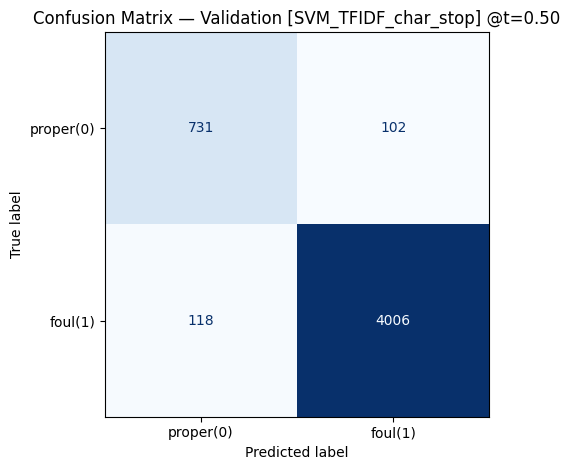


[Training] NB_BOW_char_stop

== Validation [NB_BOW_char_stop] @ threshold=0.50 ==
Accuracy: 0.9354 | Precision: 0.9810 | Recall: 0.9406 | F1(weighted): 0.9378
F1(macro): 0.8930 | ROC-AUC: 0.9670 | PR-AUC: 0.9933

Classification report:
               precision    recall  f1-score   support

           0     0.7557    0.9100    0.8257       833
           1     0.9810    0.9406    0.9604      4124

    accuracy                         0.9354      4957
   macro avg     0.8684    0.9253    0.8930      4957
weighted avg     0.9432    0.9354    0.9378      4957



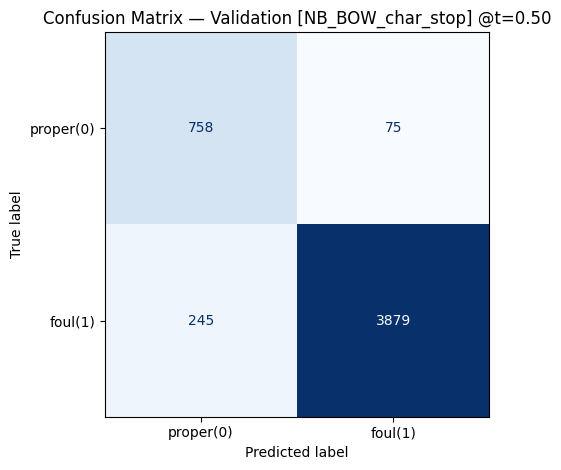


== Selected best model: SVM_TFIDF_char_stop @ t=0.50 ==


In [13]:

comparisons = {}
best_choice = None
DEFAULT_THRESHOLD = 0.50

for name, model in MODELS.items():
    print(f"\n[Training] {name}")
    model.fit(X_train_os, y_train_os)

    if hasattr(model, "predict_proba"):
        proba_val = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        proba_val = model.decision_function(X_val)
    else:
        proba_val = model.predict(X_val).astype(float)

    m_05, cm = evaluate_probs(
        proba_val, y_val,
        threshold=DEFAULT_THRESHOLD,
        title=f"Validation [{name}]",
        save_cm_path=str(CM_PNG)
    )

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['proper(0)', 'foul(1)']
    )
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title(f'Confusion Matrix — Validation [{name}] @t={DEFAULT_THRESHOLD:.2f}')
    plt.tight_layout()
    plt.show()

    comparisons[name] = {"@0.50": m_05}

    key = (m_05["f1_weighted"], m_05["precision"], m_05["roc_auc"])
    if (best_choice is None) or (key > best_choice["key"]):
        best_choice = {"name": name, "model": model, "threshold": DEFAULT_THRESHOLD, "key": key}

best_name = best_choice["name"]
best_model = best_choice["model"]
best_threshold = best_choice["threshold"]
print(f"\n== Selected best model: {best_name} @ t={best_threshold:.2f} ==")


## Save Artifacts

After selecting the best-performing model, all essential outputs are stored for reproducibility and deployment.
A custom NpEncoder class ensures that NumPy data types (e.g., integers, floats, arrays) are properly converted to JSON-compatible formats.
- metrics.json records each model’s evaluation results and the final selection with its threshold.
- model.pkl stores the trained pipeline, allowing seamless reloading for inference via the API or other scripts.
- confusion_matrix.png provides a visual summary of classification performance for validation.

This step guarantees that both the model and its evaluation artifacts are fully portable and ready for downstream integration.

In [14]:

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

with open(METRICS_PATH, "w", encoding="utf-8") as f:
    json.dump({"comparison": comparisons, "selected": {"model": best_name, "threshold": float(best_threshold)}},
              f, indent=2, cls=NpEncoder)
print(f"Saved metrics to {METRICS_PATH}")

with open(MODEL_PATH, "wb") as f:
    pickle.dump({"pipeline": best_model, "threshold": float(best_threshold)}, f)
print(f"Saved model artifact to {MODEL_PATH}")
print(f"Confusion matrix image saved to {CM_PNG}")


Saved metrics to artifacts/metrics.json
Saved model artifact to artifacts/model.pkl
Confusion matrix image saved to artifacts/confusion_matrix.png



## What We Learned (Team Reflection)

- **Preprocessing consistency is critical.** When training removed or altered punctuation, we needed to mirror that at inference; otherwise, obfuscated forms like *“f*ck”* vs *“f ck”* produce unstable behavior.
- **Lightweight classical models are strong baselines.** With TF‑IDF (uni+bi) and simple oversampling, we observed competitive weighted F1 and robust precision/recall trade‑offs.
- **Threshold matters.** We validated that adjusting `t` between 0.3–0.7 can substantially change recall and precision, which is important depending on our policy goals (e.g., minimizing false negatives vs false positives).
- **Explainability helps collaboration.** Using simple pipelines and exporting `metrics.json` enabled our team to review results and align on the selected model quickly.
- **Future work.** We plan to embed our cleaning into the vectorizer (`preprocessor=`) so the artifact self‑contains preprocessing, and to explore n‑gram ranges `(1,3)` plus mild class‑weight tuning for recall in edge cases.

---

Notebook generated on **2025-10-27 18:20 (UTC)**.
